# DeepSphere using SHREC17 dataset
### Benchmark with Cohen method S2CNN[[1]](http://arxiv.org/abs/1801.10130) and Esteves method[[2]](http://arxiv.org/abs/1711.06721)
Multi-class classification of 3D objects, using the interesting property of rotation equivariance.

The 3D objects are projected on a unit sphere.
Cohen and Esteves use equiangular sampling, while our method use a HEAlpix sampling

Several features are collected:
* projection ray length (from sphere border to intersection [0, 2])
* cos/sin with surface normal
* same features using the convex hull of the 3D object

## 0.1 Load libs

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import shutil
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "2"  # change to chosen GPU to use, nothing if work on CPU

import numpy as np
import time
import matplotlib.pyplot as plt
import healpy as hp

In [3]:
from deepsphere import models, experiment_helper, plot, utils
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset
import hyperparameters

from SHREC17.load_shrec import fix_dataset, Shrec17Dataset, Shrec17DatasetCache, Shrec17DatasetTF

## 0.2 Define parameters

In [4]:
Nside = 32
experiment_type = 'CNN' # 'FCN'
ename = '_'+experiment_type
datapath = '../data/shrec17/' # localisation of the .obj files

In [5]:
noise_dataset = True    # use perturbed dataset (Cohen and Esteves do the same)
augmentation = 3        # number of element per file (1 = no augmentation of dataset)
nfeat = 1

## 1 Load dataset

In [6]:
# if datasets are already downloaded but not preprocessed
fix = False
download = False
if fix:
    fix_dataset(datapath+'val_perturbed')
    fix_dataset(datapath+'test_perturbed')

download dataset if True, preprocess data and store it in npy files, and load it in a dataset object

In [7]:
# train_dataset = Shrec17Dataset(datapath, 'train', perturbed=noise_dataset, download=download, nside=Nside, augmentation=augmentation, nfile=None, load=False)


Better to keep validation and testing set in RAM, but not always possible

In [7]:
val_dataset = Shrec17DatasetCache(datapath, 'val', perturbed=noise_dataset, download=download, nside=Nside, nfeat=nfeat, augmentation=1, nfile=None)

In [8]:
val_nonrot_dataset = Shrec17DatasetCache(datapath, 'val', perturbed=noise_dataset, download=download, nside=Nside, nfeat=nfeat, experiment='deepsphere_norot', augmentation=1, nfile=None)

Try do make a tensorflow dataset object

In [9]:
train_TFDataset = Shrec17DatasetTF(datapath, 'train', perturbed=noise_dataset, download=download, nside=Nside, nfeat=nfeat, augmentation=augmentation, nfile=None, experiment='deepsphere_norot')

In [20]:
dataset = train_TFDataset.get_tf_dataset(32)

In [21]:
import tensorflow as tf
from tqdm import tqdm

#dataset = tf_dataset_file(datapath, dataset, file_pattern, 32, Nside, augmentation)
data_next = dataset.make_one_shot_iterator().get_next()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
steps = train_TFDataset.N // 32 + 1
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
#     try:
    for i in tqdm(range(steps)):
        print(i)
        out = sess.run(data_next)
        print(out)
#     except tf.errors.OutOfRangeError:
#         print("Done") 

  0%|          | 0/2941 [00:00<?, ?it/s]

0


  0%|          | 4/2941 [00:01<19:54,  2.46it/s]  

(array([[[ 2.56975204e-01,  3.21843028e-01,  1.41190290e+00,
          4.30433661e-01, -3.13996601e+00,  1.70375323e+00],
        [ 3.24425757e-01,  3.59575927e-01,  1.39655459e+00,
          3.49945426e-01, -2.84426713e+00,  1.67121470e+00],
        [ 1.15441591e-01,  2.91704297e-01,  1.42227662e+00,
          6.55411035e-02, -2.56625724e+00,  1.62602794e+00],
        ...,
        [ 5.61447501e-01,  1.46674323e+00, -1.10275626e+00,
          1.48660541e+00,  5.97934186e-01, -3.68855536e-01],
        [ 5.63825130e-01,  1.47733903e+00, -1.20092738e+00,
          1.48977053e+00,  6.33972526e-01, -4.24228430e-01],
        [ 5.65756977e-01,  1.36203921e+00, -4.44686413e-01,
          1.49248087e+00,  1.26861364e-01,  2.17174158e-01]],

       [[ 3.49564441e-02,  6.72209501e-01,  1.16204524e+00,
          6.06047809e-01, -1.69734907e+00,  1.38703847e+00],
        [ 6.09789193e-02,  6.90182507e-01,  1.14224637e+00,
          6.45247757e-01, -1.63554692e+00,  1.36391687e+00],
        [-1.1543

  0%|          | 11/2941 [00:01<08:10,  5.97it/s]

7
(array([[[ 1.021127  ,  0.7550521 ,  1.0643744 , -0.07328757,
          1.1792324 , -1.8491081 ],
        [ 1.0293903 ,  0.7224997 ,  1.10473   , -0.08214316,
          1.1573813 , -1.7235025 ],
        [ 1.0145087 ,  0.7837568 ,  1.0265721 , -0.07049306,
          1.1861691 , -1.8957801 ],
        ...,
        [-0.98415816,  0.48332816,  1.3273289 , -1.0060213 ,
         -1.5130208 ,  1.3154439 ],
        [-0.8192014 ,  0.5193129 ,  1.3015889 , -0.7444478 ,
         -1.3022012 ,  1.2234863 ],
        [ 0.9458827 ,  1.3656224 , -0.462043  , -0.8658441 ,
         -1.4050748 ,  1.2697468 ]],

       [[-1.1605713 ,  1.2034681 ,  0.15800606, -1.0955424 ,
          0.83322364, -0.7745814 ],
        [-1.1124474 ,  1.2299184 ,  0.07442003, -1.0606269 ,
          0.8863712 , -0.884962  ],
        [-1.1875336 ,  1.1891903 ,  0.20104519, -1.0862799 ,
          0.84719974, -0.80273795],
        ...,
        [-1.040958  ,  0.41495743,  1.3692029 , -0.83667034,
         -0.7945428 ,  0.9525161 ],

  1%|          | 18/2941 [00:02<05:34,  8.73it/s]


14
(array([[[ 5.96459448e-01, -8.54299784e-01,  4.77564096e-01,
         -1.81023705e+00,  3.27494770e-01, -6.40571071e-03],
        [ 5.98836660e-01, -8.62894893e-01,  4.56861377e-01,
         -1.73027992e+00,  4.15234983e-01, -1.15094379e-01],
        [-1.02722228e+00, -6.88725591e-01,  8.16684067e-01,
         -1.83272588e+00,  3.03501487e-01,  2.20606830e-02],
        ...,
        [-6.50826931e-01, -7.08733559e-01,  7.81056762e-01,
          2.84094010e-02, -8.22899997e-01,  9.69694197e-01],
        [ 8.67038310e-01,  1.15480505e-01, -2.07069898e+00,
          7.15399384e-02, -7.82014370e-01,  9.44842637e-01],
        [-6.78539693e-01, -6.93955123e-01,  8.07498753e-01,
         -1.28651981e-03, -8.67406130e-01,  9.96132612e-01]],

       [[-4.89533573e-01,  1.42269218e+00, -7.77697921e-01,
          2.27266774e-01,  8.83262873e-01, -8.78246784e-01],
        [-4.77898210e-01,  1.43400109e+00, -8.51887465e-01,
          2.41266519e-01,  9.22149181e-01, -9.64887381e-01],
        [-4.

  1%|          | 26/2941 [00:02<04:16, 11.35it/s]


(array([[[-0.70128834,  1.5172254 , -1.8162724 , -0.06712972,
          1.2096834 , -2.107549  ],
        [-0.70292187,  1.5157557 , -1.7697394 , -0.06842796,
          1.2064359 , -2.0697336 ],
        [-0.69845617,  1.5197611 , -1.928996  , -0.06390747,
          1.2177603 , -2.2386928 ],
        ...,
        [ 0.12635544, -1.1291711 , -0.43554413, -1.6872929 ,
          0.66817546, -0.47872055],
        [ 0.12980306, -1.1349915 , -0.46365434, -1.6707846 ,
          0.6881773 , -0.51152974],
        [ 0.12021238, -1.1189333 , -0.38754407, -1.716708  ,
          0.6329727 , -0.4226645 ]],

       [[ 0.4604697 ,  0.62157696,  1.2138638 ,  0.87306845,
          1.1131513 , -1.524623  ],
        [ 0.44322738,  0.6009867 ,  1.2333117 ,  0.878724  ,
          1.1403953 , -1.6406163 ],
        [ 0.48990846,  0.6610825 ,  1.1739291 ,  0.8743675 ,
          1.1193807 , -1.5496724 ],
        ...,
        [ 0.69786954,  1.331819  , -0.30689293,  0.89077175,
          1.0007824 , -1.1613215 ],


  1%|          | 34/2941 [00:02<03:34, 13.55it/s]

(array([[[ 0.8670383 ,  0.1154805 , -2.070699  ,  0.42164138,
         -0.6419478 ,  0.8554372 ],
        [ 0.8670383 ,  0.1154805 , -2.070699  ,  0.45202872,
         -0.5778305 ,  0.8121974 ],
        [ 0.8670383 ,  0.1154805 , -2.070699  ,  0.3640293 ,
         -0.7563582 ,  0.9289666 ],
        ...,
        [ 1.3833953 , -0.890397  ,  0.38818064,  0.06993158,
          1.0297538 , -1.2431366 ],
        [ 1.3608619 , -0.9362961 ,  0.26454926,  0.07814451,
          1.0511535 , -1.3079003 ],
        [ 1.3697951 , -0.91760683,  0.31633133,  0.08397114,
          1.0664558 , -1.3568982 ]],

       [[ 1.1613054 , -0.9378386 ,  0.2601822 , -1.2982312 ,
         -0.9614834 ,  1.0499775 ],
        [ 1.1565633 ,  1.0071146 ,  0.65079355, -1.4366368 ,
         -1.0727676 ,  1.1102381 ],
        [ 1.1682861 , -0.74145514,  0.71987176, -1.200168  ,
         -0.87654275,  1.0014824 ],
        ...,
        [ 0.27841955,  0.7661396 ,  1.0500237 ,  1.1512506 ,
         -1.3743706 ,  1.2562212 ],
 

  1%|▏         | 42/2941 [00:02<03:09, 15.31it/s]

(array([[[ 0.20726776,  1.4587852 , -1.0355726 , -0.88203156,
         -1.6597737 ,  1.3730853 ],
        [ 0.20237993,  1.4491551 , -0.9601713 , -0.7398637 ,
         -1.5530155 ,  1.3316569 ],
        [ 0.21225904,  1.4692235 , -1.1247555 , -0.7827292 ,
         -1.5864143 ,  1.3449045 ],
        ...,
        [-0.92941356,  0.63357604,  1.2021024 , -0.8218382 ,
         -1.3048719 ,  1.2247218 ],
        [-1.1006852 ,  0.6905332 ,  1.1418525 , -0.84384143,
         -1.3236481 ,  1.233354  ],
        [-1.0807471 ,  0.69665587,  1.1349305 , -0.9386016 ,
         -1.2969402 ,  1.2210476 ]],

       [[ 0.1794498 ,  0.71000093,  1.1195357 , -1.7232794 ,
          0.17218986,  0.16936812],
        [ 0.22341879,  0.75061566,  1.0700294 , -1.618624  ,
         -1.6936803 ,  1.3856903 ],
        [ 0.17690079,  0.7232296 ,  1.1038538 , -1.7420217 ,
          0.15249828,  0.19031593],
        ...,
        [ 0.48356026,  1.4885361 , -1.3194854 ,  1.1303301 ,
          1.1524334 , -1.6982995 ],
 

  2%|▏         | 50/2941 [00:02<02:51, 16.84it/s]

(array([[[-0.91512525,  1.5159817 , -1.7764127 , -0.35409385,
          1.2028048 , -2.0321975 ],
        [-0.91975427,  1.5123533 , -1.6830113 , -0.35486323,
          1.2011316 , -2.016183  ],
        [-0.91850364,  1.5133317 , -1.705813  , -0.36142614,
          1.1869094 , -1.9010291 ],
        ...,
        [-2.340639  ,  1.5155798 , -1.7646466 , -1.999956  ,
          1.2026643 , -2.0308256 ],
        [-2.3514948 ,  1.5108572 , -1.6505585 , -2.0130181 ,
          1.1864252 , -1.8975904 ],
        [-2.3407521 ,  1.5155303 , -1.7632301 , -2.0000925 ,
          1.2024943 , -2.0291708 ]],

       [[ 0.8670383 ,  0.1154805 , -2.070699  ,  0.6030497 ,
          1.2161331 , -2.204557  ],
        [ 0.8670383 ,  0.1154805 , -2.070699  ,  0.6037451 ,
          1.2188053 , -2.2655306 ],
        [ 0.8670383 ,  0.1154805 , -2.070699  ,  0.6009875 ,
          1.2082213 , -2.0899253 ],
        ...,
        [ 1.6113803 ,  1.4975767 , -1.431945  ,  0.57080084,
          1.1407603 , -1.642297  ],
 

  2%|▏         | 55/2941 [00:03<02:43, 17.68it/s]

(array([[[ 5.13645828e-01, -8.41193140e-01,  5.08467972e-01,
          1.43426991e+00, -3.22084725e-01,  6.23763621e-01],
        [ 5.03773928e-01, -8.15194428e-01,  5.67490041e-01,
          1.42239201e+00, -4.11483228e-01,  6.92691505e-01],
        [ 5.07146835e-01, -8.23916316e-01,  5.48018515e-01,
          1.42644989e+00, -3.81492168e-01,  6.69951677e-01],
        ...,
        [-5.24074495e-01, -1.27547607e-01,  1.39702511e+00,
          1.85683414e-01, -2.77601576e+00,  1.66144776e+00],
        [-8.65930498e-01, -7.96064362e-02,  1.41597891e+00,
         -2.25632608e-01, -2.94086552e+00,  1.68358278e+00],
        [-8.35959971e-01, -8.30397084e-02,  1.41476262e+00,
         -1.89573154e-01, -2.92905998e+00,  1.68216228e+00]],

       [[ 6.66028619e-01, -7.47085810e-01,  7.08963811e-01,
         -1.99802652e-01, -6.84386611e-01,  8.83242667e-01],
        [ 6.70800686e-01, -7.68061340e-01,  6.67306364e-01,
         -1.60468727e-01, -6.27384067e-01,  8.45747054e-01],
        [ 6.5826

  2%|▏         | 63/2941 [00:03<02:32, 18.92it/s]


59
(array([[[ 0.8257829 ,  0.9486265 ,  0.76472133,  1.7322932 ,
         -0.70486313,  0.89643246],
        [ 0.82748395,  0.98444813,  0.69642293,  1.7373912 ,
         -0.58348227,  0.8160698 ],
        [ 0.8252928 ,  0.9388409 ,  0.7826038 ,  1.7305446 ,
         -0.744293  ,  0.92142475],
        ...,
        [ 0.8927379 , -0.82096857,  0.5546358 ,  1.6695737 ,
         -0.39172682,  0.6777546 ],
        [ 0.8916806 , -0.86115557,  0.46107924,  1.6773883 ,
         -0.25353202,  0.56849563],
        [ 0.8925424 , -0.8281489 ,  0.5384511 ,  1.6710187 ,
         -0.36703068,  0.65885013]],

       [[ 0.37553442,  0.9131555 ,  0.8280313 ,  0.9719812 ,
         -0.8300906 ,  0.9740087 ],
        [ 0.38381112,  0.92681754,  0.8041371 ,  0.98591685,
         -0.78571725,  0.9471159 ],
        [ 0.35182533,  0.87644786,  0.8893172 ,  0.92990154,
         -0.9560085 ,  1.0469183 ],
        ...,
        [ 0.06135678,  1.2005935 ,  0.16678382,  0.89009005,
          0.11962587,  0.22467166

  2%|▏         | 71/2941 [00:03<02:23, 19.99it/s]

(array([[[-2.7113464 , -1.288862  , -1.9328991 , -2.4459844 ,
          1.2172531 , -2.2272685 ],
        [-2.7089746 , -1.2897934 , -2.0200374 , -2.443129  ,
          1.220457  , -2.329038  ],
        [-2.7154396 , -1.2872573 , -1.8533155 , -2.450909  ,
          1.2117386 , -2.1343925 ],
        ...,
        [ 0.33940598, -1.2896321 , -1.9971392 ,  1.2246269 ,
          1.2199033 , -2.3023458 ],
        [ 0.3384026 , -1.286965  , -1.8417817 ,  1.2234194 ,
          1.2107316 , -2.1208992 ],
        [ 0.33877936, -1.2879661 , -1.8842226 ,  1.2238729 ,
          1.2141738 , -2.170454  ]],

       [[-0.06767967,  0.9556871 ,  0.7516162 ,  0.4217036 ,
         -0.7013086 ,  0.8941533 ],
        [-0.08749531,  0.93824464,  0.78368306,  0.39116988,
         -0.7618314 ,  0.93237185],
        [-0.10146336,  0.9263785 ,  0.8049144 ,  0.37062517,
         -0.80115664,  0.9565458 ],
        ...,
        [-0.6806727 ,  1.4925799 , -1.3674707 , -0.24461406,
          1.030768  , -1.2461162 ],
 

  3%|▎         | 80/2941 [00:03<02:15, 21.12it/s]

(array([[[ 1.4038212 ,  0.2624318 ,  1.4307646 ,  0.24975054,
         -1.691631  ,  1.384936  ],
        [ 1.3020694 ,  0.2968031 ,  1.4206384 ,  0.35458696,
         -1.5579392 ,  1.3336266 ],
        [ 1.5664616 ,  0.22826055,  1.4387093 ,  0.20574185,
         -1.0402541 ,  1.0930061 ],
        ...,
        [ 0.6846473 ,  1.508418  , -1.6025077 ,  0.86185163,
          1.1780372 , -1.841475  ],
        [ 0.6855847 ,  1.515614  , -1.7656292 ,  0.8669792 ,
          1.202782  , -2.0319757 ],
        [ 0.6852593 ,  1.5131073 , -1.7004586 ,  0.8651989 ,
          1.1941621 , -1.9558613 ]],

       [[ 0.34239727, -1.1457921 , -0.5175273 ,  1.1919305 ,
          0.8299497 , -0.7680687 ],
        [ 0.34693617, -1.1567987 , -0.5749246 ,  1.1996746 ,
          0.88208073, -0.8757023 ],
        [ 0.35273117, -1.0542401 , -0.11901334,  1.1944389 ,
          0.84670115, -0.8017231 ],
        ...,
        [ 0.19524774, -1.129353  , -0.43641323,  1.0506936 ,
          0.6568638 , -0.46047944],
 

  3%|▎         | 89/2941 [00:04<02:08, 22.12it/s]

(array([[[ 0.7409103 ,  1.1387073 ,  0.3428386 ,  0.13671094,
         -0.09324702,  0.43034652],
        [ 0.7368994 ,  1.1071697 ,  0.42408663,  0.08192398,
         -0.20169188,  0.52523   ],
        [ 0.7414267 ,  1.142913  ,  0.33159965,  0.14376329,
         -0.07878525,  0.41722143],
        ...,
        [ 0.7013121 ,  0.89423424,  0.86014205, -0.40404812,
         -0.9338112 ,  1.0344216 ],
        [ 0.6897438 ,  0.843421  ,  0.9409943 , -0.5620413 ,
         -1.1085315 ,  1.1288438 ],
        [ 0.6929534 ,  0.8568431 ,  0.9203764 , -0.5182068 ,
         -1.0623832 ,  1.1047673 ]],

       [[-0.8763827 ,  0.46546367,  1.3391502 , -0.4085943 ,
         -2.305073  ,  1.5702524 ],
        [-0.8216538 , -0.245925  ,  1.3316642 , -0.34239894,
         -2.277917  ,  1.563691  ],
        [-1.1254014 ,  0.4217673 ,  1.3654379 , -0.698327  ,
         -2.4132428 ,  1.594951  ],
        ...,
        [ 0.16883075,  1.1967534 ,  0.17842   ,  0.912929  ,
          0.46653646, -0.18229227],
 

  3%|▎         | 97/2941 [00:04<02:04, 22.86it/s]

(array([[[ 0.8266537 , -0.93815345,  0.25928906, -1.4590951 ,
         -1.0537437 ,  1.1001923 ],
        [ 0.8265301 , -0.9349368 ,  0.2683858 , -1.6103486 ,
         -1.1652479 ,  1.1576148 ],
        [ 0.8277469 , -0.9674647 ,  0.17336506, -1.5324194 ,
         -1.1090404 ,  1.129106  ],
        ...,
        [ 0.80256194, -0.5444594 ,  1.0377692 , -1.8962016 ,
          0.65851575, -0.46312952],
        [ 0.7971628 , -0.49346665,  1.1024126 , -1.8054413 ,
          0.7642659 , -0.64347714],
        [ 0.8014862 , -0.53363234,  1.0520437 , -1.8511049 ,
          0.71041405, -0.5488762 ]],

       [[ 0.10894545, -1.2898308 , -2.0270383 ,  0.18914458,
          1.2205867 , -2.3372557 ],
        [ 0.10852749, -1.2890562 , -1.9459431 ,  0.18822372,
          1.2179233 , -2.2425516 ],
        [ 0.10825856, -1.2885584 , -1.9146916 ,  0.18763116,
          1.2162114 , -2.2060544 ],
        ...,
        [ 0.9668797 , -1.1551135 , -0.56596154, -0.7425601 ,
          0.36540285, -0.05245115],
 

  4%|▎         | 105/2941 [00:04<02:01, 23.37it/s]

(array([[[-1.4075409 ,  1.481384  , -1.2416893 , -0.8772691 ,
          1.0850744 , -1.4200882 ],
        [-1.4198314 ,  1.4740431 , -1.1691602 , -0.8920568 ,
          1.0598321 , -1.3353888 ],
        [-1.3933362 ,  1.4899677 , -1.3360989 , -0.8601774 ,
          1.1145908 , -1.5303432 ],
        ...,
        [ 0.28327033, -0.20868525,  1.355129  , -0.54961705,
         -0.7023122 ,  0.8947971 ],
        [ 0.29169345, -0.21343118,  1.3522888 , -0.51058257,
         -0.654395  ,  0.86365867],
        [ 0.33397698, -0.23952115,  1.3358928 , -0.46829033,
         -0.6006647 ,  0.8277693 ]],

       [[-1.5802097 , -0.7528173 ,  0.6977423 , -1.0994376 ,
         -0.5249085 ,  0.7753542 ],
        [-1.521263  , -0.90952295,  0.33810282, -1.0249356 ,
         -0.44517916,  0.71779156],
        [-1.6671757 , -0.7230401 ,  0.75476104, -1.1997818 ,
         -0.6214987 ,  0.8418095 ],
        ...,
        [-1.1676549 , -0.90664095,  0.3457759 , -0.6365846 ,
          0.16261052,  0.17959376],
 

  4%|▍         | 113/2941 [00:04<01:58, 23.88it/s]


107
(array([[[ 0.23276289, -0.28177243,  1.3064896 ,  1.0829653 ,
         -0.48654324,  0.7479703 ],
        [ 0.29158145, -1.2869531 , -1.8413253 ,  1.1131896 ,
         -0.5287588 ,  0.7780708 ],
        [ 0.23166724, -0.28280804,  1.305724  ,  1.0815494 ,
         -0.654151  ,  0.8634979 ],
        ...,
        [ 0.7171751 , -1.177126  , -0.68861943,  1.0771927 ,
         -0.5179947 ,  0.7704618 ],
        [ 0.76849574, -0.9127982 ,  0.3293261 ,  1.0511549 ,
         -0.6176495 ,  0.83922744],
        [ 0.7705198 , -0.934364  ,  0.26999894,  1.0468888 ,
         -0.6333671 ,  0.8497371 ]],

       [[-1.6456394 , -1.2407256 , -1.147162  , -1.2137856 ,
          1.2060379 , -2.0654044 ],
        [-1.6379136 , -1.2449083 , -1.1866112 , -1.2087876 ,
          1.2084229 , -2.0922925 ],
        [-1.6683729 , -1.2285652 , -1.0416263 , -1.2219574 ,
          1.1932611 , -1.9486744 ],
        ...,
        [-1.5767264 , -1.2889662 , -1.939734  , -1.2161843 ,
          1.1909093 , -1.9304461

  4%|▍         | 121/2941 [00:04<01:55, 24.43it/s]

(array([[[ 0.5433715 , -0.3175457 ,  1.278779  ,  1.3615835 ,
         -2.0995352 ,  1.5169207 ],
        [ 0.5388547 , -0.31158596,  1.2835777 ,  1.3547242 ,
         -2.120086  ,  1.5226375 ],
        [ 0.5091591 , -0.2761492 ,  1.3106087 ,  1.3099428 ,
         -2.241637  ,  1.5546969 ],
        ...,
        [ 0.62597626, -1.1477219 , -0.5274005 ,  1.5552337 ,
          0.01441781,  0.32977787],
        [ 0.6293658 , -1.1657376 , -0.62359977,  1.56124   ,
          0.08744536,  0.25758588],
        [ 0.6295319 , -1.1666341 , -0.6285916 ,  1.5629802 ,
          0.10915934,  0.23545338]],

       [[-1.748151  ,  0.9994862 ,  0.6663668 , -1.307358  ,
         -0.40742433,  0.68963593],
        [-1.810285  ,  0.9806223 ,  0.7039361 , -1.3811612 ,
         -0.48039946,  0.7435313 ],
        [-1.6591306 ,  1.0308429 ,  0.6008998 , -1.2109156 ,
         -0.30677667,  0.61160874],
        ...,
        [-1.3112279 ,  1.1787684 ,  0.231602  , -0.9514596 ,
          0.03577893,  0.3090092 ],
 

  4%|▍         | 125/2941 [00:05<01:54, 24.63it/s]

(array([[[ 0.64223623, -0.8407369 ,  0.5095294 ,  1.5602331 ,
          0.34303674, -0.02512214],
        [ 0.64593744, -0.8567425 ,  0.4717161 ,  1.5642886 ,
          0.39736763, -0.092347  ],
        [ 0.6345721 , -0.80921096,  0.5806613 ,  1.5540876 ,
          0.2634506 ,  0.06846565],
        ...,
        [ 0.93819577, -0.5492742 ,  1.0313243 ,  1.7778019 ,
         -1.6713775 ,  1.3774287 ],
        [ 0.93232626, -0.609037  ,  0.94616973,  1.7859367 ,
         -1.4567338 ,  1.2919726 ],
        [ 0.93495506, -0.58099145,  0.9873395 ,  1.7821217 ,
         -1.5630174 ,  1.3356519 ]],

       [[ 0.4723659 , -1.2383542 , -1.1255785 ,  0.345426  ,
         -0.24633338,  0.5625651 ],
        [ 0.46864778, -1.2257227 , -1.0186105 ,  0.37273324,
         -0.18452187,  0.51061   ],
        [ 0.4720757 , -1.2373108 , -1.1162491 ,  0.37998548,
         -0.16772202,  0.4961615 ],
        ...,
        [-0.8145095 , -0.25345042,  1.3265916 , -2.1616254 ,
          1.1508178 , -1.6902709 ],
 

  5%|▍         | 133/2941 [00:05<01:54, 24.48it/s]

(array([[[-0.07125946, -0.9846555 ,  0.12026071, -1.006106  ,
         -1.2928365 ,  1.2191405 ],
        [-0.081324  , -0.972999  ,  0.15649827, -0.89827794,
         -1.2021693 ,  1.175868  ],
        [-0.04899036, -1.0113999 ,  0.03323098, -1.1564152 ,
         -1.4084067 ,  1.2712003 ],
        ...,
        [-0.20586449, -0.9926573 ,  0.09480586,  0.20032634,
         -0.19405946,  0.5187493 ],
        [-0.18026875, -1.0197397 ,  0.00490386,  0.276018  ,
         -0.03069148,  0.37273   ],
        [-0.2056131 , -0.99291706,  0.09397127,  0.23856667,
         -0.11343031,  0.44847357]],

       [[-0.5747825 , -0.8484391 ,  0.49148098, -0.77025884,
          0.97054654, -1.0818825 ],
        [-0.5507295 , -0.7363129 ,  0.7297343 , -0.7691354 ,
          0.9725044 , -1.0868646 ],
        [-0.52618694, -0.7570838 ,  0.68931097, -0.8002434 ,
          0.91888785, -0.9573899 ],
        ...,
        [ 0.05271601, -1.2840198 , -1.7479126 ,  0.5031404 ,
          0.15276068,  0.1900385 ],
 

  5%|▍         | 139/2941 [00:05<01:54, 24.58it/s]

(array([[[-1.3043516 , -0.790628  ,  0.6206242 , -1.0434765 ,
         -0.5471228 ,  0.7909491 ],
        [-1.2261435 , -0.82448316,  0.54674196, -0.9362381 ,
         -0.42957154,  0.70622367],
        [-1.3088379 , -0.7887597 ,  0.62456477, -1.0477691 ,
         -0.5516477 ,  0.7941027 ],
        ...,
        [-1.3660485 , -1.067423  , -0.16953082, -0.96222603,
          0.56614053, -0.32161352],
        [-1.4342903 , -1.032346  , -0.03907184, -1.038433  ,
          0.45627472, -0.16861968],
        [-1.3864201 , -1.0567293 , -0.1284087 , -0.9830231 ,
          0.53557366, -0.27751788]],

       [[ 0.56386966, -1.2612703 , -1.3632008 ,  1.1803486 ,
         -0.11636926,  0.45109487],
        [ 0.5656441 , -1.270311  , -1.4843401 ,  1.1589353 ,
         -0.22321142,  0.54334825],
        [ 0.56295633, -1.2571341 , -1.3144448 ,  1.1789643 ,
         -0.12348177,  0.4574192 ],
        ...,
        [ 0.3704721 , -0.7856929 ,  0.6310031 ,  0.7928524 ,
         -1.3861991 ,  1.2614598 ],
 

  5%|▍         | 146/2941 [00:05<01:53, 24.70it/s]

(array([[[-0.36762756, -1.2800469 , -1.6537136 ,  0.37394392,
          1.1869442 , -1.9012793 ],
        [-0.36866096, -1.2788798 , -1.6298887 ,  0.37270054,
          1.1829306 , -1.873456  ],
        [-0.36355528, -1.2846649 , -1.7659731 ,  0.37884364,
          1.2028233 , -2.0323787 ],
        ...,
        [-0.48307335,  1.4094766 , -0.6968036 , -0.16628428,
          0.46376082, -0.17858212],
        [-0.47493693,  1.417322  , -0.7441318 , -0.11853516,
          0.56214213, -0.3157737 ],
        [-0.46786106,  1.4242228 , -0.7874516 , -0.12670694,
          0.5449704 , -0.2909405 ]],

       [[-0.3513073 ,  1.4385626 , -0.88331556,  0.39357516,
          0.93781984, -1.0015546 ],
        [-0.34021243,  1.4507217 , -0.97204965,  0.4069246 ,
          0.979631  , -1.1051793 ],
        [-0.34638003,  1.443935  , -0.92157686,  0.39950386,
          0.9562945 , -1.0462385 ],
        ...,
        [ 0.16580306,  1.5150651 , -1.7502126 ,  1.0157589 ,
          1.2008947 , -2.0139732 ],
 

  5%|▌         | 150/2941 [00:06<01:52, 24.78it/s]

146
(array([[[ 0.09462738,  1.3798064 , -0.53318447, -0.81431866,
         -1.1697049 ,  1.1598378 ],
        [ 0.0985206 ,  1.3862107 , -0.56668365, -0.78536206,
         -1.1429694 ,  1.1464199 ],
        [ 0.08221329,  1.3598073 , -0.43399248, -0.6850013 ,
         -1.04853   ,  1.097421  ],
        ...,
        [-0.60230196, -0.3896536 ,  1.2147936 , -0.92510515,
          0.24461798,  0.08982347],
        [-0.65378207, -0.36779574,  1.2353628 , -1.0240827 ,
          0.11225067,  0.23227675],
        [-0.5514438 , -0.40266234,  1.2020553 , -0.95334405,
          0.20590337,  0.13284178]],

       [[-0.34658736, -0.20670302,  1.3563024 , -0.8842753 ,
         -0.7310917 ,  0.9131163 ],
        [-0.2366194 , -0.23880522,  1.3363606 , -0.8027089 ,
         -0.6428333 ,  0.85602397],
        [-0.49411806, -0.1717827 ,  1.3757335 , -0.9846246 ,
         -0.8327294 ,  0.97558796],
        ...,
        [ 1.0658847 ,  1.470445  , -1.1357955 , -0.27292684,
         -0.10143077,  0.43772298

  5%|▌         | 157/2941 [00:06<01:51, 24.97it/s]

(array([[[ 8.7292051e-01, -7.7253956e-01,  6.5819931e-01,  5.1870340e-01,
          8.6221151e-02,  2.5882423e-01],
        [ 8.7275177e-01, -7.9874694e-01,  6.0333747e-01,  5.4651040e-01,
          1.6453843e-01,  1.7754103e-01],
        [ 8.7280566e-01, -7.9025638e-01,  6.2140900e-01,  5.3458285e-01,
          1.3054205e-01,  2.1334638e-01],
        ...,
        [-1.2880198e+00, -3.4256241e-01,  1.2578304e+00, -1.0876541e+00,
         -2.1349032e+00,  1.5267060e+00],
        [-1.0028632e+00, -3.1284222e-01,  1.2825723e+00, -6.9528168e-01,
         -2.3046088e+00,  1.5701414e+00],
        [-1.2092407e+00, -3.5994172e-01,  1.2425016e+00, -9.6032298e-01,
         -2.0682166e+00,  1.5080413e+00]],

       [[ 3.9765424e-01, -6.9363278e-01,  8.0806768e-01, -1.5354118e+00,
         -7.9856336e-01,  9.5496756e-01],
        [ 4.1782781e-01, -7.2996855e-01,  7.4177378e-01, -1.3947691e+00,
         -6.7698461e-01,  8.7843877e-01],
        [ 3.9634052e-01, -6.9137400e-01,  8.1204355e-01, -1.5261

  6%|▌         | 163/2941 [00:06<01:51, 25.02it/s]

(array([[[ 0.8670383 ,  0.1154805 , -2.070699  , -1.6185349 ,
          0.8613326 , -0.8318206 ],
        [ 0.8670383 ,  0.1154805 , -2.070699  , -1.592431  ,
          0.89516073, -0.90414053],
        [ 0.8670383 ,  0.1154805 , -2.070699  , -1.6610383 ,
          0.8073315 , -0.7239006 ],
        ...,
        [-1.1785924 , -0.48163876,  1.1164881 , -0.6017959 ,
         -1.558444  ,  1.3338283 ],
        [-1.2016405 , -0.47498602,  1.1242571 , -0.6295271 ,
         -1.5813203 ,  1.3429011 ],
        [-1.2500851 , -1.0608842 , -0.14423777, -0.68781453,
          0.43334   , -0.1384836 ]],

       [[ 0.8576631 , -0.6953484 ,  0.8050367 , -0.8410133 ,
         -0.8236539 ,  0.9701474 ],
        [ 0.8572245 , -0.65906286,  0.86713564, -0.96739984,
         -0.9483046 ,  1.0425981 ],
        [ 0.85782504, -0.7095873 ,  0.779507  , -0.7944088 ,
         -0.7746936 ,  0.94033504],
        ...,
        [ 0.85992694, -0.95344645,  0.21515577, -0.18891203,
          0.06392647,  0.2812067 ],
 

  6%|▌         | 169/2941 [00:06<01:50, 25.02it/s]

(array([[[-1.3599085 ,  1.0735737 ,  0.50515884, -0.8199567 ,
         -0.3172164 ,  0.6199096 ],
        [-1.2868934 ,  1.1060517 ,  0.42687264, -0.7321057 ,
         -0.2055382 ,  0.5284853 ],
        [-1.3800167 ,  1.0649999 ,  0.5250062 , -0.84415066,
         -0.3466979 ,  0.64308757],
        ...,
        [ 0.6085748 ,  1.2293432 ,  0.07629403, -1.1703535 ,
         -0.72791624,  0.9111089 ],
        [ 0.59852344,  1.1876482 ,  0.20561118, -1.0116266 ,
         -0.5684885 ,  0.8057709 ],
        [ 0.60486   ,  1.213562  ,  0.12671895, -1.1306816 ,
         -0.6896556 ,  0.88665044]],

       [[ 0.5759258 , -1.2570132 , -1.3130696 , -0.31532663,
          0.8082158 , -0.7256009 ],
        [ 0.5744383 , -1.2500343 , -1.237681  , -0.34356162,
          0.75156784, -0.6206073 ],
        [ 0.57442224, -1.2499596 , -1.2369114 , -0.29694247,
          0.8458963 , -0.80008703],
        ...,
        [-2.435517  ,  1.0860229 ,  0.47574255, -2.3469744 ,
          0.7433714 , -0.6060358 ],
 

  6%|▌         | 173/2941 [00:06<01:50, 25.13it/s]


(array([[[-0.5178896 ,  0.80650514,  0.995085  ,  0.1100627 ,
         -1.2355444 ,  1.1920509 ],
        [-0.5661373 ,  0.78324175,  1.027269  ,  0.04911735,
         -1.3155376 ,  1.2296364 ],
        [-0.577033  ,  0.7782034 ,  1.0340513 ,  0.03535416,
         -1.3328624 ,  1.2375569 ],
        ...,
        [ 0.8670383 ,  0.1154805 , -2.070699  , -0.5900862 ,
          0.03843186,  0.3064102 ],
        [ 0.8670383 ,  0.1154805 , -2.070699  , -0.5078504 ,
          0.16522974,  0.17680435],
        [ 0.8670383 ,  0.1154805 , -2.070699  , -0.5711922 ,
          0.06680552,  0.27833444]],

       [[-0.53609717,  1.1106193 ,  0.41545114, -0.17986077,
         -0.16351824,  0.49252388],
        [-0.5281481 ,  1.1162792 ,  0.40115193, -0.16106497,
         -0.131442  ,  0.46446577],
        [-0.58337724,  1.0781802 ,  0.49435785, -0.24672453,
         -0.2729848 ,  0.5843996 ],
        ...,
        [-1.8565223 , -0.69249177,  0.8100781 , -1.41747   ,
         -0.8334138 ,  0.975997  ],


  6%|▌         | 179/2941 [00:07<01:50, 25.10it/s]

(array([[[-0.54471886, -1.0968093 , -0.289486  , -0.6719651 ,
          0.9229548 , -0.966746  ],
        [-0.5512402 , -1.0912352 , -0.26588833, -0.6731113 ,
          0.8940978 , -0.90180594],
        [-0.50582445, -0.77182764,  0.65965235, -0.7028886 ,
          0.86822844, -0.84624445],
        ...,
        [-0.48964074, -0.8286661 ,  0.53727674, -0.09492378,
          0.38983774, -0.08285754],
        [-0.10340811,  0.95032996,  0.76157516, -0.04028923,
          0.50491637, -0.23451354],
        [-0.45224503, -0.72371066,  0.75351137, -0.07867908,
          0.42337728, -0.12557   ]],

       [[ 0.16758583, -0.7370334 ,  0.72835827, -0.90812033,
         -0.0335109 ,  0.37537456],
        [ 0.19426934, -0.7708458 ,  0.66165286, -0.8325094 ,
          0.06699102,  0.27814916],
        [ 0.5464112 , -1.241806  , -1.157178  , -0.9060342 ,
         -0.03081189,  0.37284297],
        ...,
        [ 0.8989344 , -0.4818316 ,  1.1162612 , -1.2080406 ,
          0.86378443, -0.83693135],
 

  6%|▋         | 185/2941 [00:07<01:50, 24.96it/s]

(array([[[ 2.0477332e-01, -8.3472228e-01,  5.2343643e-01,  1.3070394e-01,
         -7.2419658e-02,  4.1140783e-01],
        [ 1.8763226e-01, -8.1069368e-01,  5.7741147e-01,  8.6849257e-02,
         -1.5998214e-01,  4.8945680e-01],
        [ 2.2283052e-01, -8.6129797e-01,  4.6073446e-01,  1.6579506e-01,
          9.0947887e-04,  3.4276769e-01],
        ...,
        [ 3.0531433e-01, -9.7422707e-01,  1.5272614e-01,  6.3232340e-02,
         -2.1572706e-01,  5.3707266e-01],
        [ 2.8152636e-01, -9.2995483e-01,  2.8235117e-01, -2.7301073e-02,
         -3.7867621e-01,  6.6779703e-01],
        [ 2.9528573e-01, -9.5511401e-01,  2.1025315e-01,  3.2443345e-02,
         -2.7295512e-01,  5.8437532e-01]],

       [[ 1.3676079e-01,  6.9508910e-01,  1.1367103e+00,  2.5849849e-02,
         -3.7874159e-01,  6.6784728e-01],
        [ 1.3524300e-01,  6.9143724e-01,  1.1408362e+00,  7.9658724e-02,
         -2.8100005e-01,  5.9090114e-01],
        [ 1.8459494e-01,  7.3571527e-01,  1.0886625e+00, -1.8233

  6%|▋         | 191/2941 [00:07<01:50, 24.97it/s]

(array([[[-1.6885482 , -0.35850775,  1.2437907 , -1.4445235 ,
         -1.2482889 ,  1.198152  ],
        [-1.5322812 , -0.6590506 ,  0.86715597, -1.2717344 ,
         -1.1178694 ,  1.1336423 ],
        [-1.6507183 , -0.58454955,  0.9822367 , -1.516913  ,
         -1.2571886 ,  1.2023869 ],
        ...,
        [ 0.14909334, -1.2803478 , -1.6600797 ,  0.9956    ,
          1.1883335 , -1.9112921 ],
        [ 0.15191962, -1.2858644 , -1.8028004 ,  0.9989823 ,
          1.207201  , -2.0782247 ],
        [ 0.14978813, -1.2817001 , -1.690036  ,  0.9964367 ,
          1.1929884 , -1.946521  ]],

       [[-0.43313622,  1.4849249 , -1.2791984 ,  0.28935477,
          1.0972539 , -1.4639055 ],
        [-0.42994416,  1.4882952 , -1.3167281 ,  0.29320964,
          1.1088425 , -1.5077311 ],
        [-0.44323888,  1.474366  , -1.1722192 ,  0.27715456,
          1.0609457 , -1.338972  ],
        ...,
        [-2.462323  ,  1.4864202 , -1.2956126 , -2.1521072 ,
          1.1024002 , -1.483093  ],
 

  7%|▋         | 197/2941 [00:07<01:50, 24.87it/s]

(array([[[ 0.503649  ,  1.3968949 , -0.6246911 , -0.8514356 ,
         -0.16560169,  0.49432784],
        [ 0.5083196 ,  1.4135786 , -0.7213067 , -0.7968874 ,
         -0.09483676,  0.43178242],
        [ 0.5007868 ,  1.3868798 , -0.57023627, -0.79981065,
         -0.09870237,  0.43526807],
        ...,
        [ 0.49569204,  1.2336164 ,  0.06230937,  0.48278132,
          0.17580919,  0.1654874 ],
        [ 0.4906278 ,  1.218573  ,  0.11091172,  0.46103778,
          0.11691908,  0.22746696],
        [ 0.4987695 ,  1.2429606 ,  0.03121365,  0.49325687,
          0.20485027,  0.13399558]],

       [[-1.293135  ,  0.99943423,  0.66647196, -1.1944954 ,
         -0.7507326 ,  0.92545617],
        [-1.3721443 ,  0.9682439 ,  0.72788125, -1.2955709 ,
         -0.8423871 ,  0.9813484 ],
        [-1.2421792 ,  1.0207893 ,  0.62231284, -1.0923877 ,
         -0.6517694 ,  0.861929  ],
        ...,
        [-0.8809348 ,  1.2154727 ,  0.12071379, -0.34723032,
          0.4944098 , -0.22004397],
 

  7%|▋         | 203/2941 [00:08<01:50, 24.87it/s]

(array([[[ 0.18155628, -1.0604979 , -0.14275809,  1.0299217 ,
          0.39944386, -0.09497319],
        [ 0.1885802 , -1.0726724 , -0.19018589,  1.0382364 ,
          0.440053  , -0.14724469],
        [ 0.1675775 , -1.0389633 , -0.06274021,  1.0122895 ,
          0.31596074,  0.00734261],
        ...,
        [ 0.05947888, -1.0729336 , -0.19122194,  0.11815775,
         -1.6163201 ,  1.3565438 ],
        [ 0.03813208, -1.0423284 , -0.07493628,  0.292437  ,
         -1.5208    ,  1.3186277 ],
        [ 0.04231526, -1.0482012 , -0.09648826,  0.19634777,
         -1.5225095 ,  1.3193251 ]],

       [[ 0.66744274, -0.9143173 ,  0.3252352 ,  1.5200977 ,
         -0.83468926,  0.97675914],
        [ 0.6662747 , -0.92079294,  0.3076486 ,  1.5302632 ,
         -0.74894124,  0.9243362 ],
        [ 0.66188794, -0.8864329 ,  0.3983166 ,  1.5064973 ,
         -0.94169074,  1.0388747 ],
        ...,
        [ 0.6960762 , -1.1066858 , -0.33235848,  1.6383263 ,
          0.27492878,  0.05530501],
 

  7%|▋         | 206/2941 [00:08<01:50, 24.78it/s]

203
(array([[[-1.9698735 ,  1.4003966 , -0.64432514, -1.5538524 ,
          0.8065973 , -0.7224901 ],
        [-2.0048575 ,  1.3847443 , -0.5589329 , -1.5959446 ,
          0.7527754 , -0.6227668 ],
        [-1.9891354 ,  1.3917311 , -0.5963101 , -1.5770279 ,
          0.77680033, -0.66641676],
        ...,
        [-1.2210197 ,  1.0542395 ,  0.5494535 , -0.65284693,
         -0.38369286,  0.67163336],
        [-1.2527378 ,  1.040193  ,  0.58061534, -0.69100976,
         -0.43199345,  0.70802516],
        [-1.1899855 ,  1.0684026 ,  0.51716876, -0.61550707,
         -0.3349919 ,  0.6339307 ]],

       [[-0.7495407 ,  1.3469222 , -0.3739363 , -0.08556899,
          0.6227217 , -0.40672413],
        [-0.7630064 ,  1.3367492 , -0.3284043 , -0.1017707 ,
          0.5877407 , -0.35355037],
        [-0.7741339 ,  1.3284688 , -0.29247263, -0.11515917,
          0.5592677 , -0.3115891 ],
        ...,
        [ 0.13011144,  1.4915781 , -1.3552693 , -0.03400744,
          1.1201326 , -1.5527483 

  7%|▋         | 212/2941 [00:08<01:50, 24.79it/s]

(array([[[ 0.8670383 ,  0.1154805 , -2.070699  ,  0.8323279 ,
          0.38453534, -0.07620946],
        [ 0.8670383 ,  0.1154805 , -2.070699  ,  0.81168723,
          0.46883655, -0.18537332],
        [ 0.8670383 ,  0.1154805 , -2.070699  ,  0.8351211 ,
          0.56218565, -0.3158369 ],
        ...,
        [-0.38272566,  1.2783245 , -0.09339271,  0.35577366,
          0.38469002, -0.07640282],
        [-0.3605771 ,  1.2986712 , -0.17065291,  0.38242504,
          0.45679927, -0.16931544],
        [-0.3574026 ,  1.301739  , -0.18269579,  0.3862446 ,
          0.4673482 , -0.18337892]],

       [[ 0.9468234 , -0.78146243,  0.6398237 ,  0.61667573,
          0.3295935 , -0.00891991],
        [ 0.94538957, -0.79787594,  0.60520494,  0.64129955,
          0.40926027, -0.10745105],
        [ 0.94450146, -0.8083482 ,  0.5825481 ,  0.6235997 ,
          0.35167387, -0.03561982],
        ...,
        [-0.8227985 , -0.66458094,  0.857959  , -0.19714473,
         -0.75277656,  0.926733  ],
 

  7%|▋         | 218/2941 [00:08<01:50, 24.74it/s]


214
(array([[[ 1.2005408 , -0.717152  ,  0.76566774,  0.00545413,
          0.12773502,  0.21626641],
        [ 1.2123978 , -0.68856716,  0.8169609 ,  0.01959469,
          0.1564745 ,  0.18610853],
        [ 1.2082204 , -0.6984114 ,  0.7996013 ,  0.04691776,
          0.2132731 ,  0.12474287],
        ...,
        [ 1.9063513 , -0.15170117,  1.385856  , -0.8043919 ,
          1.0033634 , -1.1683675 ],
        [ 2.0999901 , -0.1097394 ,  1.4045622 , -0.7675405 ,
          1.0681026 , -1.3623205 ],
        [ 2.109233  , -0.10806361,  1.4052413 , -0.7854512 ,
          1.0364128 , -1.2628585 ]],

       [[ 2.8705244 , -1.1224777 , -0.40396038, -1.0734121 ,
          0.6341572 , -0.42451712],
        [ 2.8615327 , -1.1280588 , -0.43024164, -1.0367904 ,
          0.68784314, -0.51097554],
        [ 2.9065468 , -1.1006126 , -0.30583107, -1.1150895 ,
          0.5746668 , -0.33414114],
        ...,
        [-0.93433535, -1.0397936 , -0.06573943, -1.6614885 ,
          0.09940111,  0.2454388

  8%|▊         | 225/2941 [00:09<01:49, 24.82it/s]

(array([[[ 1.49712324e+00,  9.43883061e-01,  7.73430049e-01,
          5.04420459e-01,  9.58955705e-01, -1.05281389e+00],
        [ 1.48819315e+00,  9.55793023e-01,  7.51418054e-01,
          5.12154460e-01,  9.85192358e-01, -1.11967528e+00],
        [ 1.47401869e+00,  9.75416601e-01,  7.14073300e-01,
          5.14464557e-01,  9.93086934e-01, -1.14057291e+00],
        ...,
        [ 1.89423752e+00,  7.67407179e-01,  1.04836285e+00,
         -1.18504524e+00,  1.00448763e+00, -1.17145085e+00],
        [ 1.96008658e+00,  7.28132963e-01,  1.09793353e+00,
         -1.14319992e+00,  1.06881893e+00, -1.36468828e+00],
        [ 1.89334285e+00,  7.67975390e-01,  1.04761732e+00,
         -1.16530561e+00,  1.03461313e+00, -1.25749135e+00]],

       [[ 7.37229705e-01, -1.17701101e+00, -6.87944531e-01,
         -6.18392043e-02,  8.42081428e-01, -7.92358041e-01],
        [ 7.35789955e-01, -1.16283274e+00, -6.07566714e-01,
         -8.62696618e-02,  7.86159933e-01, -6.83790803e-01],
        [ 7.3622

  8%|▊         | 228/2941 [00:09<01:49, 24.80it/s]

225
(array([[[ 0.8670383 ,  0.1154805 , -2.070699  ,  0.05447459,
          1.1279671 , -1.5855366 ],
        [ 0.8670383 ,  0.1154805 , -2.070699  ,  0.06045338,
          1.1437185 , -1.6560713 ],
        [ 0.8670383 ,  0.1154805 , -2.070699  ,  0.06153168,
          1.14657   , -1.6696061 ],
        ...,
        [ 0.53769153,  1.1937289 ,  0.18751402, -1.497314  ,
         -0.43619925,  0.7111479 ],
        [ 0.54025394,  1.2021838 ,  0.16193494, -1.538295  ,
         -0.47449934,  0.739254  ],
        [ 0.5444682 ,  1.2163824 ,  0.11784508, -1.5990727 ,
         -0.5296296 ,  0.7786845 ]],

       [[-1.5558717 , -0.95721453,  0.20405135, -1.0791559 ,
          0.13670456,  0.20691665],
        [-1.6222007 , -0.92863107,  0.28603682, -1.1564077 ,
          0.04068901,  0.30419546],
        [-1.565446  , -0.95299226,  0.21648812, -1.0905868 ,
          0.12218   ,  0.22202928],
        ...,
        [-1.2080928 , -0.67840904,  0.83454597, -0.82328117,
          0.5354069 , -0.27728066

  8%|▊         | 234/2941 [00:09<01:49, 24.81it/s]

231
(array([[[-0.2966099 , -0.75561816,  0.69221497,  0.32771587,
         -0.74177426,  0.91984403],
        [-0.2624812 , -0.7819385 ,  0.63883466,  0.3758888 ,
         -0.6572285 ,  0.86552244],
        [-0.27227002, -0.7747611 ,  0.653653  ,  0.3621567 ,
         -0.6757616 ,  0.87764305],
        ...,
        [-0.33774868,  1.0213274 ,  0.6211769 ,  0.40431547,
          0.92402667, -0.96922344],
        [-0.29190683, -0.94976336,  0.22592063,  0.42059866,
          0.9753555 , -1.0941572 ],
        [-0.33917508,  1.0196164 ,  0.6247847 ,  0.40464115,
          0.9250426 , -0.9715764 ]],

       [[-1.1527463 , -1.2775372 , -1.6040101 , -0.5707017 ,
          1.1783149 , -1.8432391 ],
        [-1.1454917 , -1.2825586 , -1.7103581 , -0.5619731 ,
          1.1955811 , -1.967435  ],
        [-1.1576087 , -1.2741916 , -1.5451297 , -0.5765519 ,
          1.1668111 , -1.7744771 ],
        ...,
        [ 0.40383586, -1.2539841 , -1.2794175 , -1.03778   ,
          1.097324  , -1.4641633 

  8%|▊         | 240/2941 [00:09<01:48, 24.84it/s]

(array([[[-0.33491364, -1.006935  ,  0.04815641,  0.28053293,
          0.34510693, -0.02763168],
        [-0.33618683, -1.0057471 ,  0.05209935,  0.27780885,
          0.3382917 , -0.01938401],
        [-0.3649282 , -0.97958934,  0.13613069,  0.24407685,
          0.2558101 ,  0.07716548],
        ...,
        [-1.3386079 , -0.36307395,  1.2396704 , -0.99093103,
         -1.9661444 ,  1.4776856 ],
        [-1.1086459 , -0.41877577,  1.1857561 , -0.69374675,
         -1.774609  ,  1.414723  ],
        [-1.1624275 , -0.40461785,  1.2001082 , -0.7632497 ,
         -1.8232921 ,  1.4314837 ]],

       [[-1.081666  , -0.40947807,  1.1952318 , -0.49139962,
         -1.7972012 ,  1.4225663 ],
        [-1.0460931 , -0.41923916,  1.1852787 , -0.44820118,
         -1.763235  ,  1.4107316 ],
        [-0.94907117, -0.44780546,  1.1549093 , -0.33254203,
         -1.6657029 ,  1.3753083 ],
        ...,
        [-1.0097643 , -0.429589  ,  1.1744907 , -0.40003857,
         -1.7233548 ,  1.3965073 ],
 

  8%|▊         | 246/2941 [00:09<01:48, 24.83it/s]

(array([[[ 6.40188038e-01,  1.19511509e+00,  1.83354095e-01,
          1.48473895e+00,  1.26674131e-01,  2.17368752e-01],
        [ 6.44711137e-01,  1.21707332e+00,  1.15661971e-01,
          1.49206078e+00,  2.01171890e-01,  1.38019666e-01],
        [ 6.43048465e-01,  1.20889616e+00,  1.41272113e-01,
          1.48941159e+00,  1.73875809e-01,  1.67561680e-01],
        ...,
        [-8.45750153e-01, -5.48946373e-02,  1.42409706e+00,
         -5.38037479e-01,  6.87417090e-01, -5.10269463e-01],
        [-4.41791475e-01, -1.07479401e-01,  1.40547681e+00,
         -4.84892391e-02, -2.87080503e+00,  1.67478168e+00],
        [-7.70666540e-01, -6.27058074e-02,  1.42165160e+00,
         -5.03557205e-01,  7.50148356e-01, -6.18073165e-01]],

       [[ 4.92054850e-01, -3.75625461e-01,  1.22811377e+00,
         -1.29692829e+00,  3.19854587e-01,  2.71490682e-03],
        [ 5.21004617e-01, -4.16711986e-01,  1.18787622e+00,
         -1.28827810e+00,  3.30658406e-01, -1.01974718e-02],
        [ 4.7933

  8%|▊         | 249/2941 [00:10<01:48, 24.86it/s]


248
(array([[[ 0.5911175 , -0.16919689,  1.37708   , -0.05679842,
         -1.409339  ,  1.2716066 ],
        [ 0.62802994, -0.21314472,  1.3524616 ,  0.05450043,
         -1.2735368 ,  1.2101115 ],
        [ 0.58792853, -0.16594398,  1.3787555 , -0.09519725,
         -1.452604  ,  1.2902201 ],
        ...,
        [ 0.5811538 , -0.8679661 ,  0.44448   ,  0.8827307 ,
         -0.05434201,  0.39477327],
        [ 0.5741777 , -0.84454006,  0.50065136,  0.9001806 ,
          0.01036727,  0.33368456],
        [ 0.5831873 , -0.8750126 ,  0.42706698,  0.8747222 ,
         -0.08327132,  0.42130533]],

       [[-0.9386662 ,  1.4352065 , -0.8601034 , -0.65215206,
          0.9424684 , -1.0126442 ],
        [-0.9574502 ,  1.4223317 , -0.7754134 , -0.6779259 ,
          0.9032581 , -0.92206424],
        [-0.94843227,  1.4280922 , -0.8124989 , -0.6647509 ,
          0.91973734, -0.95933855],
        ...,
        [-2.43929   ,  0.99695176,  0.6714917 , -2.3039448 ,
          1.1909974 , -1.9311161

KeyboardInterrupt: 

  8%|▊         | 249/2941 [00:20<03:36, 12.44it/s]

In [11]:
# import time
# import tensorflow as tf

# #dataset = tf_dataset_file(datapath, dataset, file_pattern, 32, Nside, augmentation)
# t_start = time.time()
# data_next = dataset.make_one_shot_iterator().get_next()
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# steps = train_TFDataset.N // 32 + 1
# with tf.Session(config=config) as sess:
#     sess.run(tf.global_variables_initializer())
#     try:
#         for i in range(steps):
#             out = sess.run(data_next)
#     except tf.errors.OutOfRangeError:
#         print("Done") # Never reach this as will iterate on infinite sets
# t_end = time.time()
# print(str(t_end-t_start)+" s")

# # t_start = time.time()
# # data_iter = train_dataset.iter(32)
# # steps = int(train_dataset.N / 32)
# # for i in range(steps):
# #     next(data_iter)
# #     #feed_dict = {self.ph_data: batch_data, self.ph_labels: batch_labels, self.ph_training: True}
# # t_end = time.time()
# # print(str(t_end-t_start)+" s")

## 1.1 Preprocess the dataset

Shuffle the training dataset and print the classes distribution

In [10]:
nclass = train_TFDataset.nclass
num_elem = train_TFDataset.N
#ids_train = train_dataset.ids
print('number of class:',nclass,'\nnumber of elements:',num_elem)#,'\nfirst id:',ids_train[0])

number of class: 55 
number of elements: 94092


In [13]:
# x_val, labels_val, ids_val = val_dataset.return_data(train=False)

## 2 Classification using DeepSphere

Use of the Dataset object used for other DeepSphere experiments

In [15]:
# #training = LabeledDatasetWithNoise(x_train, labels_train, end_level=sigma_noise)
# #training = LabeledDataset(x_train, labels_train)
# validation = LabeledDataset(x_val, labels_val)

In [11]:
#EXP_NAME = 'shrec17_feat_{}feat_{}aug_{}sides{}'.format(nfeat, augmentation, Nside, ename)
#EXP_NAME = 'shrec17_Cohen_simple_SGD_max_nsides_300epoch_{}sides{}'.format(Nside, ename)
#EXP_NAME = 'shrec17_newBestGraph_best_4K_triplet_all_{}aug_{}sides{}'.format(augmentation, Nside, ename)
EXP_NAME = 'essai_0loss'

Load model with hyperparameters chosen.
For each experiment, a new EXP_NAME is chosen, and new hyperparameters are store.
All informations are present 'DeepSphere/Shrec17/experiments.md'
The fastest way to reproduce an experiment is to revert to the commit of the experiment to load the correct files and notebook

Adding a layer in the fully connected can be beneficial

In [12]:
params = hyperparameters.get_params_shrec17_optim(num_elem, EXP_NAME, Nside, nclass, nfeat_in=nfeat, architecture=experiment_type)
params["tf_dataset"] = train_TFDataset.get_tf_dataset(params["batch_size"])
#params["std"] = [0.002, 0.009, 0.025, 0.09, 0.15, 0.5]
#params["full"] = [True]*6
#params["extra_loss"]=True
model = models.deepsphere(**params)

#sides: [32, 16, 8, 4, 2, 1, 1]
#pixels: [12288, 3072, 768, 192, 48, 12, 12]
#samples per batch: 32
=> #pixels per batch (input): 393,216
=> #pixels for training (input): 34,686,074,880
Learning rate will start at 5.0e-02 and finish at 5.0e-02.
NN architecture
  input: M_0 = 12288
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 12288 * 16 / 4 = 49152
    weights: F_0 * F_1 * K_1 = 1 * 16 * 4 = 64
    biases: F_1 = 16
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 3072 * 32 / 4 = 24576
    weights: F_1 * F_2 * K_2 = 16 * 32 * 4 = 2048
    biases: F_2 = 32
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 768 * 64 / 4 = 12288
    weights: F_2 * F_3 * K_3 = 32 * 64 * 4 = 8192
    biases: F_3 = 64
    batch normalization
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 192 * 128 / 4 = 6144
    weights: F_3 * F_4 * K_4 = 64 * 128 * 4 = 32768
    biases: F_4 = 128
    batch normalization
  layer 5: cgconv5
    

In [33]:
#EXP_NAME = "shrec17_best_4K_cache_1aug_128sides_CNN"
shutil.rmtree('summaries/{}/'.format(EXP_NAME), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(EXP_NAME), ignore_errors=True)

Find a correct learning rate

In [ ]:
backup = params.copy()

params, learning_rate = utils.test_learning_rates(params, train_TFDataset.N, 1e-6, 1e-1, num_epochs=20)

shutil.rmtree('summaries/{}/'.format(params['dir_name']), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(params['dir_name']), ignore_errors=True)

model = models.deepsphere(**params)
_, loss_validation, _, _ = model.fit(train_TFDataset, val_dataset, use_tf_dataset=True, cache=True)

params.update(backup)

plt.semilogx(learning_rate, loss_validation, '.-')

NN architecture
  input: M_0 = 196608
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 196608 * 16 / 4 = 786432
    weights: F_0 * F_1 * K_1 = 6 * 16 * 5 = 480
    biases: F_1 = 16
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 49152 * 32 / 4 = 393216
    weights: F_1 * F_2 * K_2 = 16 * 32 * 5 = 2560
    biases: F_2 = 32
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 12288 * 64 / 4 = 196608
    weights: F_2 * F_3 * K_3 = 32 * 64 * 5 = 10240
    biases: F_3 = 64
    batch normalization
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 3072 * 128 / 4 = 98304
    weights: F_3 * F_4 * K_4 = 64 * 128 * 5 = 40960
    biases: F_4 = 128
    batch normalization
  layer 5: cgconv5
    representation: M_4 * F_5 / p_5 = 768 * 256 / 4 = 49152
    weights: F_4 * F_5 * K_5 = 128 * 256 * 5 = 163840
    biases: F_5 = 256
    batch normalization
  Statistical layer: mean
    representation: 1 * 256 = 256
  layer 6: logits

/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 0.76 (39 / 5133), f1 (weighted): 0.80, loss: 4.29e+00
  CPU time: 1477s, wall time: 797s, perf_time_load: 1.16s, perf_time: 1.16s
step 980 / 19602 (epoch 1.00 / 20):
  learning_rate = 3.16e-06, training loss = 4.13e+00
  validation accuracy: 3.78 (194 / 5133), f1 (weighted): 2.88, loss: 4.19e+00
  CPU time: 2964s, wall time: 1587s, perf_time_load: 1.13s, perf_time: 1.13s
step 1470 / 19602 (epoch 1.50 / 20):
  learning_rate = 5.62e-06, training loss = 4.08e+00
  validation accuracy: 10.29 (528 / 5133), f1 (weighted): 4.54, loss: 4.00e+00
  CPU time: 4446s, wall time: 2374s, perf_time_load: 1.16s, perf_time: 1.16s
step 1960 / 19602 (epoch 2.00 / 20):
  learning_rate = 9.99e-06, training loss = 3.78e+00
  validation accuracy: 26.57 (1364 / 5133), f1 (weighted): 15.49, loss: 3.70e+00
  CPU time: 5924s, wall time: 3166s, perf_time_load: 1.15s, perf_time: 1.15s
step 2450 / 19602 (epoch 2.50 / 20):
  learning_rate = 1.78e-05, training loss = 3.08e+00
  validation accura

In [ ]:
shutil.rmtree('summaries/lr_finder/', ignore_errors=True)
shutil.rmtree('checkpoints/lr_finder/', ignore_errors=True)

0.9 seems to be a good learning rate for SGD with current parameters

## 2.2 Train Network

In [25]:
print("the number of parameters in the model is: {:,}".format(model.get_nbr_var()))

conv1/weights:0
conv1/bias:0
conv2/weights:0
conv2/bias:0
conv3/weights:0
conv3/bias:0
conv4/weights:0
conv4/bias:0
conv5/weights:0
conv5/bias:0
logits/weights:0
the number of parameters in the model is: 189,040


In [ ]:
accuracy_validation, loss_validation, loss_training, t_step, t_batch = model.fit(train_TFDataset, val_dataset, use_tf_dataset=True, cache=True)

step 1470 / 88211 (epoch 0.50 / 30):
  learning_rate = 5.00e-02, training accuracy = 0.00, training loss = 1.27e+00


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 70.50 (3619 / 5133), f1 (weighted): 68.07, loss: 1.20e+00
  CPU time: 120s, wall time: 61s, perf_time_load: 0.027s, perf_time: 0.028s
step 2940 / 88211 (epoch 1.00 / 30):
  learning_rate = 5.00e-02, training accuracy = 0.69, training loss = 7.47e-01
  validation accuracy: 74.93 (3846 / 5133), f1 (weighted): 72.98, loss: 9.65e-01
  CPU time: 218s, wall time: 109s, perf_time_load: 0.158s, perf_time: 0.158s
step 4410 / 88211 (epoch 1.50 / 30):
  learning_rate = 5.00e-02, training accuracy = 0.69, training loss = 6.01e-01
  validation accuracy: 76.17 (3910 / 5133), f1 (weighted): 74.97, loss: 8.86e-01
  CPU time: 320s, wall time: 157s, perf_time_load: 0.031s, perf_time: 0.031s
step 5880 / 88211 (epoch 2.00 / 30):
  learning_rate = 5.00e-02, training accuracy = 0.81, training loss = 4.40e-01
  validation accuracy: 77.21 (3963 / 5133), f1 (weighted): 76.23, loss: 8.75e-01
  CPU time: 428s, wall time: 209s, perf_time_load: 0.029s, perf_time: 0.029s
step 7350 / 88211 (ep

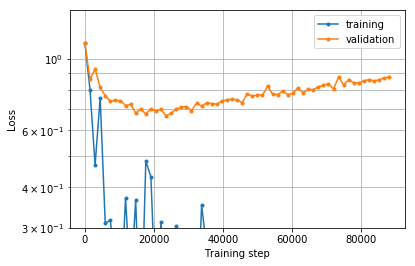

In [61]:
plot.plot_loss(loss_training, loss_validation, t_step, params['eval_frequency'])
plt.savefig('./figures/plot_overfit.png', bboxes_inches='tight')

Remarks

In [110]:
model.evaluate(x_train, labels_train)

NameError: name 'x_train' is not defined

In [ ]:
#predictions, loss = model.predict(x_val, labels_val)

In [17]:
# model.evaluate(x_val, labels_val)
model.evaluate(val_dataset, None, cache=True)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Graph_Cohen_4K_6feat_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Graph_Cohen_4K_6feat_3aug_32sides_CNN/model-166110


('accuracy: 81.41 (4179 / 5133), f1 (weighted): 80.68, loss: 7.91e-01\nCPU time: 22s, wall time: 21s',
 81.41437755698422,
 80.67557539015563,
 0.791224667511789)

In [18]:
model.evaluate(val_nonrot_dataset, None, cache=True)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Graph_Cohen_4K_6feat_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Graph_Cohen_4K_6feat_3aug_32sides_CNN/model-166110


('accuracy: 80.91 (4153 / 5133), f1 (weighted): 80.18, loss: 7.90e-01\nCPU time: 17s, wall time: 16s',
 80.90785115916617,
 80.18294874128193,
 0.7897724651951272)

In [129]:
# probabilities = model.probs(x_val, nclass)
probabilities, _ = model.probs(val_dataset, nclass, cache=True)
# if augmentation>1:
#     probabilities = probabilities.reshape((-1,augmentation,nclass))
#     probabilities = probabilities.mean(axis=1)
    #ids_val = ids_val[::repeat]
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newBestGraphFull_best_4K_triplet_norot_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newBestGraphFull_best_4K_triplet_norot_3aug_32sides_CNN/model-147018


In [135]:
# probabilities = model.probs(x_val, nclass)
probabilities, _ = model.probs(val_nonrot_dataset, nclass, cache=True)
# if augmentation>1:
#     probabilities = probabilities.reshape((-1,augmentation,nclass))
#     probabilities = probabilities.mean(axis=1)
    #ids_val = ids_val[::repeat]
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newBestGraphFull_best_4K_triplet_norot_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newBestGraphFull_best_4K_triplet_norot_3aug_32sides_CNN/model-147018


In [127]:
ids_val = val_dataset.get_ids()

In [20]:
#predictions = predictions.astype(np.int)

In [119]:
from SHREC17.load_shrec import shrec_output

In [136]:
shrec_output(model.get_descriptor(val_dataset), ids_val, probabilities, datapath, 'results/val_perturbed')

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newBestGraphFull_best_4K_triplet_norot_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newBestGraphFull_best_4K_triplet_norot_3aug_32sides_CNN/model-147018


In [137]:
# for every file, find every object with the same class, sorted by most relevance
os.makedirs(os.path.join(datapath,'results_aug/val_perturbed'), exist_ok=True)
for i,_id in enumerate(ids_val):
    idfile = os.path.join(datapath,'results_aug/val_perturbed',_id)
    # predictions batchxclass
    # pred_class batch == predictions
    retrieved = [(probabilities[j, predictions[j]], ids_val[j]) for j in range(len(ids_val)) if predictions[j] == predictions[i]]
    retrieved = sorted(retrieved, reverse=True)
    retrieved = [i for _, i in retrieved]
    with open(idfile, "w") as f:
        f.write("\n".join(retrieved))

NaN appears if remove i==j case

## test network

In [36]:
test_dataset = Shrec17Dataset(datapath, 'test', perturbed=noise_dataset, download=download, nside=Nside, augmentation=1, nfile=None)

10265it [00:10, 954.60it/s]


In [34]:
test_dataset = Shrec17DatasetCache(datapath, 'test', perturbed=noise_dataset, download=download, nside=Nside, augmentation=3, nfile=None)

In [82]:
test_nonrot_dataset = Shrec17DatasetCache(datapath, 'test', perturbed=noise_dataset, download=download, nfeat=nfeat,
                                          nside=Nside, experiment='deepsphere_norot', augmentation=augmentation, nfile=None)

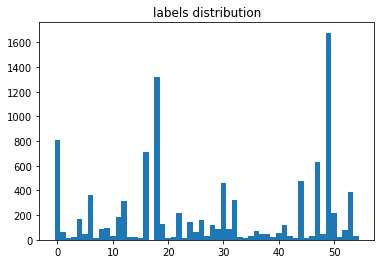

In [37]:
x_test, labels_test, ids_test = test_dataset.return_data(train=False)

In [22]:
model.evaluate(x_test, labels_test)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Graph_Cohen_4K_6feat_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Graph_Cohen_4K_6feat_3aug_32sides_CNN/model-166110


('accuracy: 76.83 (23660 / 30795), f1 (weighted): 76.66, loss: 9.70e-01\nCPU time: 64s, wall time: 57s',
 76.83065432700114,
 76.6615539577081,
 0.9696400432090013)

In [54]:
model.evaluate(test_dataset, None, cache=True)

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_feat_3feat_3aug_32sides_CNN/model-88211


ValueError: Cannot feed value of shape (32, 4096, 6) for Tensor 'inputs/data:0', which has shape '(32, 12288, 3)'

In [83]:
model.evaluate(test_nonrot_dataset, None, cache=True)

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_feat_1feat_3aug_32sides_CNN/model-88211


('accuracy: 77.37 (23827 / 30795), f1 (weighted): 77.67, loss: 1.10e+00\nCPU time: 69s, wall time: 62s',
 77.37295015424583,
 77.6732032888039,
 1.1000511187177564,
 None)

* 30 epochs, 49 min, 1.03ms/0.68ms/0.78ms
* 6 feats: acc 80.35, f1 80.54, 
* 3 feats: acc 79.45, f1 79.45
* 2 feats: acc 77.73, f1 77.91
* 1 feats: acc 77.37, f1 77.67

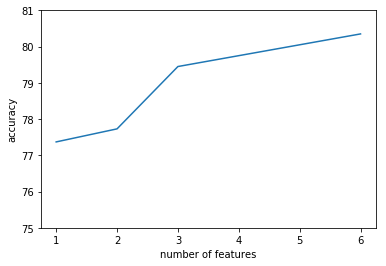

In [94]:
acc = [77.37, 77.73, 79.45, 80.35]
f1 = [77.67, 77.91, 79.45, 80.54]
feat = [1, 2, 3, 6]
plt.plot(feat, acc, label='accuracy')
# plt.plot(feat, f1)
plt.ylabel('accuracy')
plt.xlabel('number of features')
plt.ylim(75, 81)
# plt.legend()
plt.savefig('./figures/feat_inf.png', bboxes_inches='tight')

In [ ]:
#predictions = model.predict(x_test)

In [39]:
probabilities = model.probs(x_test, nclass)
# if augmentation>1:
#     probabilities = probabilities.reshape((-1,augmentation,nclass))
#     probabilities = probabilities.mean(axis=1)
#probabilities = np.log(probabilities)
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Graph_Cohen_4K_6feat_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Graph_Cohen_4K_6feat_3aug_32sides_CNN/model-166110


In [138]:
probabilities, _ = model.probs(test_nonrot_dataset, nclass, cache=True)
# if augmentation>1:
#     probabilities = probabilities.reshape((-1,augmentation,nclass))
#     probabilities = probabilities.mean(axis=1)
#probabilities = np.log(probabilities)
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newBestGraphFull_best_4K_triplet_norot_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newBestGraphFull_best_4K_triplet_norot_3aug_32sides_CNN/model-147018


In [ ]:
#predictions = predictions.astype(np.int)

write to file

In [41]:
# for every file, find every object with the same class, sorted by most relevance
os.makedirs(os.path.join(datapath,'results_aug/test_perturbed'), exist_ok=True)
for i, _id in enumerate(ids_test):
    idfile = os.path.join(datapath,'results_aug/test_perturbed',_id)
    # predictions batchxclass
    # pred_class batch == predictions
    retrieved = [(probabilities[j, predictions[j]], ids_test[j]) for j in range(len(ids_test)) if predictions[j] == predictions[i]]
    retrieved = sorted(retrieved, reverse=True)
    retrieved = [i for _, i in retrieved]
    with open(idfile, "w") as f:
        f.write("\n".join(retrieved))

In [140]:
shrec_output(model.get_descriptor(LabeledDataset(x_test, labels_test)), ids_test, probabilities, datapath, 'results/test_perturbed')

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newBestGraphFull_best_4K_triplet_norot_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newBestGraphFull_best_4K_triplet_norot_3aug_32sides_CNN/model-147018


Why not working?

In [141]:
def _print_histogram(nclass, labels_train, labels_min=None):
    if labels_train is None:
        return
    import matplotlib.pyplot as plt
    from collections import Counter
    hist_train=Counter(labels_train)
    if labels_min is not None:
        hist_min = Counter(labels_min)
        hist_temp = hist_train - hist_min
        hist_min = hist_min - hist_train
        hist_train = hist_temp + hist_min
#         for i in range(self.nclass):
#             hist_train.append(np.sum(labels_train == i))
    labels, values = zip(*hist_train.items())
    indexes = np.asarray(labels)
#     miss = set(indexes) - set(labels)
#     if len(miss) is not 0:
#         hist_train.update({elem:0 for elem in miss})
#     labels, values = zip(*hist_train.items())
    width = 1
    plt.bar(labels, values, width)
    plt.title("labels distribution")
    plt.ylim(0,1700)
    #plt.xticks(indexes + width * 0.5, labels)
    plt.show()

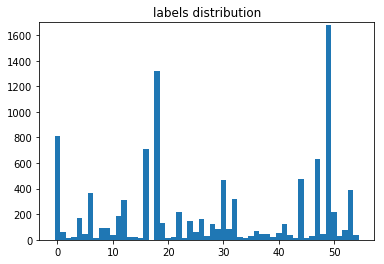

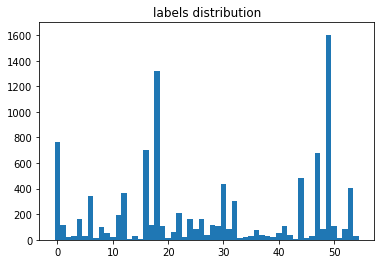

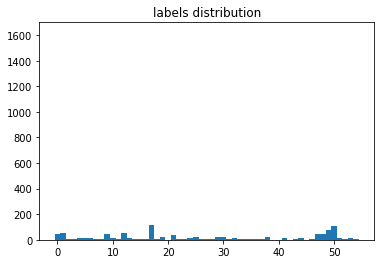

In [142]:
_print_histogram(55, labels_test)
_print_histogram(55, predictions)
_print_histogram(55, labels_test, predictions)

In [144]:
from sklearn.metrics import confusion_matrix

In [162]:
conf_mat = confusion_matrix(labels_test, predictions, range(55))

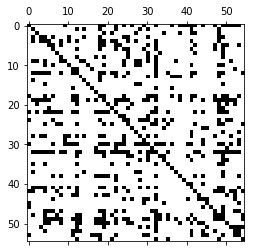

In [164]:
plt.spy(conf_mat, cmap = plt.cm.gist_heat_r)

In [187]:
lab1 = np.argsort((conf_mat-np.diag(np.diag(conf_mat))).sum(axis=1))[::-1][:7]

In [188]:
lab2 = np.argsort((conf_mat-np.diag(np.diag(conf_mat))).sum(axis=0))[::-1][:7]

In [178]:
dict_labels = {0: 'airplane',
               1: 'trashcan',
               2: 'bag',
               3: 'basket',
               4: 'bathtub',
               5: 'bed',
               6: 'bench',
               7: 'birdhouse',
               8: 'bookshelf',
               9: 'bottle',
               10: 'bowl',
               11: 'bus',
               12: 'cabinet',
               13: 'camera',
               14: 'can',
               15: 'cap',
               16: 'car',
               17: 'cellphone',
               18: 'chair',
               19: 'clock',
               20: 'keyboard',
               21: 'dishwasher',
               22: 'display',
               23: 'earphone',
               24: 'faucet',
               25: 'file cabinet',
               26: 'guitar',
               27: 'helmet',
               28: 'jar',
               29: 'knife',
               30: 'lamp',
               31: 'laptop',
               32: 'speaker',
               33: 'mailbox',
               34: 'microphone',
               35: 'microwave',
               36: 'motorcycle',
               37: 'mug',
               38: 'piano',
               39: 'pillow',
               40: 'pistol',
               41: 'flowerpot',
               42: 'printer',
               43: 'remote control',
               44: 'rifle',
               45: 'rocket',
               46: 'skateboard',
               47: 'sofa',
               48: 'stove',
               49: 'table',
               50: 'telephone',
               51: 'tower',
               52: 'train',
               53: 'vessel',
               54: 'washer'}

In [189]:
[dict_labels[lab] for lab in lab1]

['table', 'cabinet', 'telephone', 'speaker', 'lamp', 'bench', 'chair']

In [190]:
[dict_labels[lab] for lab in lab2]

['cabinet', 'table', 'speaker', 'cellphone', 'sofa', 'chair', 'lamp']